# Head

In [1]:
import pandas as pd
from pathlib import Path
home = Path.home()

# models = ['deepseek_v3', 'gemma3', 'llama4', 'qwq', 'qwen3']
models = ['deepseek_v3', 'gemma3', 'llama4', 'qwq']

# suffixes = None
suffixes = '_sent_shuffle'
# suffixes = '_tail'
if suffixes is not None:
    csv_files = [home / f'projects/TLDR/data/paper_html_10.1038/abs_annotation/generated_annotations/{model}_TLDR{suffixes}.txt' for model in models]
else:
    csv_files = [home / f'projects/TLDR/data/paper_html_10.1038/abs_annotation/generated_annotations/{model}_TLDR.txt' for model in models]

df = pd.read_csv(home / 'projects/TLDR/data/paper_html_10.1038/abs_annotation/test.tsv', sep='\t')
for model, csv_file in zip(models, csv_files):
    single_df = pd.read_csv(csv_file, sep='\t', header=None, names=[model])
    df = df.join(single_df)

for index in pd.read_csv(home / "projects/TLDR/description/invalid_entry_in_test.txt", sep='\t', header=None).values.flatten().tolist():
    df = df.drop(index-2)  # Adjusting for zero-based index
df

,doi,paper_id,abstract,annotation,deepseek_v3,gemma3,llama4,qwq
0,10.1073/pnas.91.7.2757,107202074,The origin and taxonomic status of domesticate...,A demonstration that cattle have been domestic...,This study examines mtDNA sequences from tauri...,Reference 14 reports phylogenetic analysis of ...,These authors investigated the evolutionary hi...,This study uses mitochondrial DNA sequencing t...
1,10.1093/genetics/154.4.1785,83366887,Abstract The domestic pig originates from the ...,Evidence is presented for independent domestic...,This study provides molecular evidence for the...,This study demonstrates independent domesticat...,These findings indicate that there has been ge...,This study provides molecular evidence for int...
2,10.1073/pnas.96.16.9252,122095374,We previously mapped a quantitative trait locu...,This paper shows how the identity-by-descent a...,This study reports the fine-mapping of a QTL a...,This paper reports the fine-mapping of a QTL a...,Fine mapping a QTL for milk fat percentage on ...,This study refines the mapping of a quantitati...
3,10.1101/gr.10.2.220,100831446,A genome-wide linkage disequilibrium (LD) map ...,The pattern of linkage disequilibrium (LD) acr...,This study provides an early genome-wide analy...,This paper reports an extensive LD map in dair...,This study evaluates the potential of LD mappi...,This study investigates linkage disequilibrium...
4,10.1126/science.8134840,17452622,The European wild boar was crossed with the do...,The first paper to show the use of divergent i...,This study reports the mapping of a major quan...,This study identifies a major QTL on chromosom...,This study identifies a major locus on pig chr...,This study identifies a major quantitative tra...
...,...,...,...,...,...,...,...,...
35631,10.2337/db08-1168,4860455,OBJECTIVE—Regulatory T-cells (Tregs) have cata...,This article describes the good manufacturing ...,This study demonstrates the feasibility of iso...,Reference 51 describes an optimized method for...,These studies demonstrate the feasibility of t...,This study evaluates the expansion and functio...
35632,10.1126/science.aar3246,4860145,Engineering cytokine-receptor pairs Interleuki...,This study reports the generation of an orthog...,This study describes the engineering of orthog...,Reference 54 reports the successful engineerin...,This study demonstrates that a synthetic IL-2:...,This study introduces engineered synthetic IL-...
35633,10.1126/science.aad2791,62290395,T cells target peptide combos One of the endur...,This article shows that some diabetogenic T ce...,This study identifies hybrid insulin peptides ...,This study identified that autoreactive T cell...,T cells isolated from the pancreatic islets of...,This study identifies that T cells in type 1 d...
35634,10.1073/pnas.1902566116,82979762,Polymorphic HLAs form the primary immune barri...,This article describes the development of gene...,This study describes a multiplex genome-editin...,This work describes a new method to render all...,This study provides evidence for genome-edited...,This study presents a multiplex genome-editing...


# Overlap-based

In [2]:
import evaluate

def evaluate_metrics(df, pred_col='prediction', ref_col='reference'):
    references = df[ref_col].tolist()
    predictions = df[pred_col].tolist()

    # BLEU
    bleu = evaluate.load("bleu")
    bleu_result = bleu.compute(
        predictions=predictions,                 # 每个元素是一个字符串
        references=[[ref] for ref in references] # 每个元素是字符串列表
    )

    # METEOR
    meteor = evaluate.load("meteor")
    meteor_result = meteor.compute(predictions=predictions, references=references)

    # ROUGE
    rouge = evaluate.load("rouge")
    rouge_result = rouge.compute(
        predictions=predictions,
        references=references,
        rouge_types=["rouge1", "rouge2", "rougeL"]
    )

    # 只返回需要的分数，便于后续统计平均
    rouge_f = {rouge_type: rouge_result[rouge_type] for rouge_type in ["rouge1", "rouge2", "rougeL"]}

    return {
        'bleu': bleu_result["bleu"],
        'meteor': meteor_result["meteor"],
        'rouge': rouge_f
    }

/opt/anaconda3/envs/zqlyuTLDR/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Human-written annotations as references

In [4]:
evaluate_metrics(df, pred_col='deepseek_v3', ref_col='annotation')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.02179267092351488,
 'meteor': 0.2563322425013617,
 'rouge': {'rouge1': 0.2547144813701552,
  'rouge2': 0.05767807133117349,
  'rougeL': 0.1854361689950115}}

In [5]:
evaluate_metrics(df, pred_col='qwen3', ref_col='annotation')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.011977842430480163,
 'meteor': 0.2444276480952033,
 'rouge': {'rouge1': 0.2209834534176697,
  'rouge2': 0.04533792571342782,
  'rougeL': 0.1550987958773836}}

In [6]:
evaluate_metrics(df, pred_col='gemma3', ref_col='annotation')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.028354378785504456,
 'meteor': 0.2255549493536052,
 'rouge': {'rouge1': 0.2626882369362834,
  'rouge2': 0.058558148680244365,
  'rougeL': 0.20057745028537174}}

In [7]:
evaluate_metrics(df, pred_col='llama4', ref_col='annotation')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.009904643788902805,
 'meteor': 0.20799707466094394,
 'rouge': {'rouge1': 0.24170650962713458,
  'rouge2': 0.05085344815132424,
  'rougeL': 0.18393278221885823}}

In [8]:
evaluate_metrics(df, pred_col='qwq', ref_col='annotation')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.01285771302581912,
 'meteor': 0.2450748916074611,
 'rouge': {'rouge1': 0.20656905858011987,
  'rouge2': 0.04361105879283017,
  'rougeL': 0.14461114502749456}}

## Abstracts as references

In [10]:
evaluate_metrics(df, pred_col='annotation', ref_col='abstract')

[nltk_data] Downloading package wordnet to /home/zqlyu2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/zqlyu2/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zqlyu2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.00014032267591655747,
 'meteor': np.float64(0.06377415902193286),
 'rouge': {'rouge1': np.float64(0.14085859607012607),
  'rouge2': np.float64(0.03824179502459642),
  'rougeL': np.float64(0.10052529701258925)}}

In [11]:
evaluate_metrics(df, pred_col='deepseek_v3', ref_col='abstract')

[nltk_data] Downloading package wordnet to /home/zqlyu2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/zqlyu2/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zqlyu2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.00842050749244403,
 'meteor': np.float64(0.14812199928907163),
 'rouge': {'rouge1': np.float64(0.2740809317573329),
  'rouge2': np.float64(0.09751437713848274),
  'rougeL': np.float64(0.17701385090721455)}}

In [12]:
evaluate_metrics(df, pred_col='qwen3', ref_col='abstract')

[nltk_data] Downloading package wordnet to /home/zqlyu2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/zqlyu2/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zqlyu2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.03319207318259169,
 'meteor': np.float64(0.19749892250719794),
 'rouge': {'rouge1': np.float64(0.3397127836850643),
  'rouge2': np.float64(0.1271640602084576),
  'rougeL': np.float64(0.20906792437643631)}}

In [13]:
evaluate_metrics(df, pred_col='gemma3', ref_col='abstract')

[nltk_data] Downloading package wordnet to /home/zqlyu2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/zqlyu2/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zqlyu2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.0010656112738437911,
 'meteor': np.float64(0.10773691656048064),
 'rouge': {'rouge1': np.float64(0.20425126373918268),
  'rouge2': np.float64(0.08153386518596661),
  'rougeL': np.float64(0.14585628909336387)}}

In [14]:
evaluate_metrics(df, pred_col='llama4', ref_col='abstract')

[nltk_data] Downloading package wordnet to /home/zqlyu2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/zqlyu2/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zqlyu2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.019022986071808298,
 'meteor': np.float64(0.10089574445128485),
 'rouge': {'rouge1': np.float64(0.19638098124993508),
  'rouge2': np.float64(0.06747216340315135),
  'rougeL': np.float64(0.13168214142120832)}}

In [ ]:
evaluate_metrics(df, pred_col='qwq', ref_col='abstract')

[nltk_data] Downloading package wordnet to /home/zqlyu2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/zqlyu2/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zqlyu2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.053145877507336486,
 'meteor': np.float64(0.25059843651245906),
 'rouge': {'rouge1': np.float64(0.4034028101899118),
  'rouge2': np.float64(0.16457917019185242),
  'rougeL': np.float64(0.2571935840136871)}}

: 

## Multi-annotated abstracts as a human-evaluation baseline

In [9]:
full = pd.read_csv('/home/lyuzhuoqi/projects/TLDR/data/paper_html_10.1038/abs_annotation/abs_annotation.tsv', sep='\t')
print('# of papers: ', full['paper_id'].nunique())

multi_annotated = full[full['paper_id'].isin(full['paper_id'].value_counts()[full['paper_id'].value_counts() > 1].index)]
display(multi_annotated)
print(multi_annotated['paper_id'].unique().shape[0], 'papers are annotated by multiple annotators')

# of papers:  29356


,abs_doi,paper_id,abstract,annotation
0,10.1073/pnas.91.7.2757,107202074,The origin and taxonomic status of domesticate...,A demonstration that cattle have been domestic...
1,10.1093/genetics/154.4.1785,83366887,Abstract The domestic pig originates from the ...,Evidence is presented for independent domestic...
7,10.1083/jcb.153.2.397,58551536,The correct positioning of the nucleus is ofte...,Using live imaging and computer simulation the...
8,10.1101/gad.14.6.690,131922988,E2F is a family of transcription factors that ...,"Disruption of mouse E2f3 , but not E2f1 , redu..."
10,10.1101/gad.859201,18000382,Telomere shortening is the mechanism underlyin...,Growing primary human keratinocytes and mammar...
...,...,...,...,...
35633,10.1126/scitranslmed.aad4134,103721459,Autologous regulatory T cells can be expanded ...,First clinical trial demonstrating up to 1 yea...
35634,10.1084/jem.20040139,83080620,The low number of CD4+ CD25+ regulatory T cell...,Seminal study showing that antigen-specific T ...
35637,10.1126/science.aar3246,4860145,Engineering cytokine-receptor pairs Interleuki...,This study reports the generation of an orthog...
35638,10.1126/science.aad2791,62290395,T cells target peptide combos One of the endur...,This article shows that some diabetogenic T ce...


4019 papers are annotated by multiple annotators


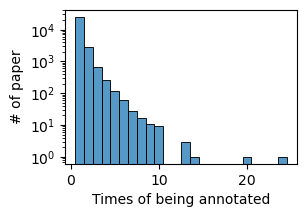

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

paper_id_counts = full['paper_id'].value_counts()
plt.figure(figsize=(3, 2))
sns.histplot(paper_id_counts, bins=30, stat='count', discrete=True)
plt.yscale('log')
plt.xlabel('Times of being annotated')
plt.ylabel('# of paper')
plt.show()

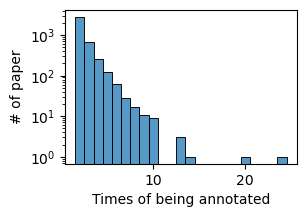

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

paper_id_counts = multi_annotated['paper_id'].value_counts()
plt.figure(figsize=(3, 2))
sns.histplot(paper_id_counts, bins=30, stat='count', discrete=True)
plt.yscale('log')
plt.xlabel('Times of being annotated')
plt.ylabel('# of paper')
plt.show()

In [ ]:
import random
from tqdm import tqdm

all_scores = []
n_sample = 10  # 抽样次数

for _ in tqdm(range(n_sample)):
    grouped = multi_annotated.groupby('paper_id')
    results = []
    for paper_id, group in grouped:
        annotations = group['annotation'].tolist()
        if len(annotations) < 2:
            continue
        ref = random.choice(annotations)
        preds = [a for a in annotations if a != ref]
        for pred in preds:
            results.append({'paper_id': paper_id, 'reference': ref, 'prediction': pred})

    eval_df = pd.DataFrame(results)
    scores = evaluate_metrics(eval_df, pred_col='prediction', ref_col='reference')
    all_scores.append(scores)

  0%|                                                                                     | 0/10 [00:00<?, ?it/s][nltk_data] Downloading package wordnet to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 10%|███████▋                                                                     | 1/10 [00:13<01:57, 13.04s/it][nltk_data] Downloading package wordnet to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /h

KeyError: 'rouge3'

In [ ]:
# 计算平均分
bleu_avg = sum(s['bleu'] for s in all_scores) / n_sample
meteor_avg = sum(s['meteor'] for s in all_scores) / n_sample
rouge_avg = {}
for rouge_type in ["rouge1", "rouge2", "rougeL"]:
    rouge_avg[rouge_type] = sum(s['rouge'][rouge_type] for s in all_scores) / n_sample

print("=== 10次抽样平均 ===")
print("BLEU: {:.4f}".format(bleu_avg))
print("METEOR: {:.4f}".format(meteor_avg))
print("ROUGE (F):")
for rouge_type in ["rouge1", "rouge2", "rougeL"]:
    print("  {}: {:.4f}".format(rouge_type.upper(), rouge_avg[rouge_type]))

=== 10次抽样平均 ===
BLEU: 0.0453
METEOR: 0.2158
ROUGE (F):
  ROUGE1: 0.2738
  ROUGE2: 0.0677
  ROUGEL: 0.2163


# Simlarity-based

## BERTScore

In [4]:
from bert_score import score

def evaluate_bertscore(df, pred_col='prediction', ref_col='reference'):
    preds = df[pred_col].tolist()
    refs = df[ref_col].tolist()

    P, R, F1 = score(preds, refs, lang='en', verbose=True)  # 如果是中文，改为 lang='zh'
    print(f"BERTScore F1: {F1.mean().item():.4f}")
    return {
        "BERTScore_P": P.mean().item(),
        "BERTScore_R": R.mean().item(),
        "BERTScore_F1": F1.mean().item()
    }


/opt/anaconda3/envs/zqlyuTLDR/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Human-wrtten annotations as references

In [24]:
evaluate_bertscore(df, pred_col='deepseek_v3', ref_col='annotation')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1111 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/557 [00:00<?, ?it/s]

done in 379.09 seconds, 93.96 sentences/sec
BERTScore F1: 0.8752


{'BERTScore_P': 0.859603226184845,
 'BERTScore_R': 0.8917859792709351,
 'BERTScore_F1': 0.8752175569534302}

In [17]:
evaluate_bertscore(df, pred_col='qwen3', ref_col='annotation')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1113 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/557 [00:00<?, ?it/s]

done in 564.50 seconds, 63.10 sentences/sec
BERTScore F1: 0.8646


{'BERTScore_P': 0.8417383432388306,
 'BERTScore_R': 0.8892121315002441,
 'BERTScore_F1': 0.8646422624588013}

In [27]:
evaluate_bertscore(df, pred_col='gemma3', ref_col='annotation')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1113 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/557 [00:00<?, ?it/s]

done in 283.89 seconds, 125.48 sentences/sec
BERTScore F1: 0.8802


{'BERTScore_P': 0.8740829229354858,
 'BERTScore_R': 0.886883556842804,
 'BERTScore_F1': 0.8802496194839478}

In [28]:
evaluate_bertscore(df, pred_col='llama4', ref_col='annotation')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1113 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/557 [00:00<?, ?it/s]

done in 316.19 seconds, 112.66 sentences/sec
BERTScore F1: 0.8771


{'BERTScore_P': 0.8746355772018433,
 'BERTScore_R': 0.8801242113113403,
 'BERTScore_F1': 0.8771476745605469}

In [29]:
evaluate_bertscore(df, pred_col='qwq', ref_col='annotation')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1113 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/557 [00:00<?, ?it/s]

done in 608.11 seconds, 58.58 sentences/sec
BERTScore F1: 0.8607


{'BERTScore_P': 0.83527010679245,
 'BERTScore_R': 0.8880637288093567,
 'BERTScore_F1': 0.8606795072555542}

#### Multi-annotated abstracts as a human-evaluation baseline

In [30]:
import random
from tqdm import tqdm

all_scores = []
n_sample = 10  # 抽样次数

for _ in tqdm(range(n_sample)):
    grouped = multi_annotated.groupby('paper_id')
    results = []
    for paper_id, group in grouped:
        annotations = group['annotation'].tolist()
        if len(annotations) < 2:
            continue
        ref = random.choice(annotations)
        preds = [a for a in annotations if a != ref]
        for pred in preds:
            results.append({'paper_id': paper_id, 'reference': ref, 'prediction': pred})

    eval_df = pd.DataFrame(results)
    scores = evaluate_bertscore(eval_df, pred_col='prediction', ref_col='reference')
    all_scores.append(scores)

# 计算平均分
bertscore_avg = sum(s['BERTScore_F1'] for s in all_scores) / n_sample

print("=== 10次抽样平均 ===")
print("BERTScore: {:.4f}".format(bertscore_avg))

  0%|                                                                                    | 0/10 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 10%|███████▌                                                                    | 1/10 [00:38<05:50, 39.00s/it]

done in 37.19 seconds, 168.93 sentences/sec
BERTScore F1: 0.8811


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 20%|███████████████▏                                                            | 2/10 [01:16<05:04, 38.12s/it]

done in 37.41 seconds, 167.90 sentences/sec
BERTScore F1: 0.8812


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 30%|██████████████████████▊                                                     | 3/10 [01:55<04:28, 38.29s/it]

done in 37.74 seconds, 166.45 sentences/sec
BERTScore F1: 0.8812


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 40%|██████████████████████████████▍                                             | 4/10 [02:33<03:50, 38.42s/it]

done in 37.65 seconds, 166.86 sentences/sec
BERTScore F1: 0.8813


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 50%|██████████████████████████████████████                                      | 5/10 [03:12<03:12, 38.51s/it]

done in 37.83 seconds, 166.05 sentences/sec
BERTScore F1: 0.8813


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████▌                              | 6/10 [03:50<02:33, 38.31s/it]

done in 37.71 seconds, 166.58 sentences/sec
BERTScore F1: 0.8811


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████▏                      | 7/10 [04:28<01:55, 38.43s/it]

done in 37.82 seconds, 166.09 sentences/sec
BERTScore F1: 0.8813


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████▊               | 8/10 [05:07<01:16, 38.48s/it]

done in 37.64 seconds, 166.84 sentences/sec
BERTScore F1: 0.8814


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████▍       | 9/10 [05:45<00:38, 38.45s/it]

done in 37.64 seconds, 166.86 sentences/sec
BERTScore F1: 0.8811


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [06:24<00:00, 38.49s/it]

done in 37.97 seconds, 165.43 sentences/sec
BERTScore F1: 0.8813
=== 10次抽样平均 ===
BERTScore: 0.8812


### Abstracts as references

In [5]:
evaluate_bertscore(df, pred_col='annotation', ref_col='abstract')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1014/1014 [05:34<00:00,  3.03it/s]


computing greedy matching.


100%|██████████| 557/557 [00:17<00:00, 31.90it/s]


done in 354.50 seconds, 100.48 sentences/sec
BERTScore F1: 0.8410


{'BERTScore_P': 0.8739364147186279,
 'BERTScore_R': 0.8107424378395081,
 'BERTScore_F1': 0.840957522392273}

In [6]:
evaluate_bertscore(df, pred_col='deepseek_v3', ref_col='abstract')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1012/1012 [06:15<00:00,  2.69it/s]


computing greedy matching.


100%|██████████| 557/557 [00:16<00:00, 33.20it/s]


done in 395.40 seconds, 90.09 sentences/sec
BERTScore F1: 0.8718


{'BERTScore_P': 0.8991764187812805,
 'BERTScore_R': 0.8462992906570435,
 'BERTScore_F1': 0.8717939257621765}

In [8]:
evaluate_bertscore(df, pred_col='qwen3', ref_col='abstract')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1014/1014 [06:49<00:00,  2.48it/s]


computing greedy matching.


100%|██████████| 557/557 [00:18<00:00, 30.23it/s]


done in 431.02 seconds, 82.64 sentences/sec
BERTScore F1: 0.8773


{'BERTScore_P': 0.89637291431427,
 'BERTScore_R': 0.859321653842926,
 'BERTScore_F1': 0.877304196357727}

In [7]:
evaluate_bertscore(df, pred_col='gemma3', ref_col='abstract')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1014/1014 [05:40<00:00,  2.97it/s]


computing greedy matching.


100%|██████████| 557/557 [00:15<00:00, 36.17it/s]


done in 358.71 seconds, 99.30 sentences/sec
BERTScore F1: 0.8630


{'BERTScore_P': 0.8985253572463989,
 'BERTScore_R': 0.8303980231285095,
 'BERTScore_F1': 0.8629780411720276}

In [9]:
evaluate_bertscore(df, pred_col='llama4', ref_col='abstract')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1014/1014 [05:51<00:00,  2.89it/s]


computing greedy matching.


100%|██████████| 557/557 [00:15<00:00, 34.89it/s]


done in 369.92 seconds, 96.29 sentences/sec
BERTScore F1: 0.8556


{'BERTScore_P': 0.8905962705612183,
 'BERTScore_R': 0.8236058354377747,
 'BERTScore_F1': 0.8555719256401062}

In [10]:
evaluate_bertscore(df, pred_col='qwq', ref_col='abstract')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1014/1014 [07:26<00:00,  2.27it/s]


computing greedy matching.


100%|██████████| 557/557 [00:19<00:00, 28.21it/s]


done in 469.97 seconds, 75.79 sentences/sec
BERTScore F1: 0.8867


{'BERTScore_P': 0.9028448462486267,
 'BERTScore_R': 0.8713891506195068,
 'BERTScore_F1': 0.8867055773735046}

## MoverScore

In [3]:
%load_ext autoreload
%autoreload 2

In [6]:
import sys
sys.path.append(str(home / 'projects/TLDR/evaluation/ref_based'))

from moverscore_v2 import get_idf_dict, word_mover_score 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import numpy as np

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def evaluate_moverscore(df, pred_col='prediction', ref_col='reference'):
    preds = df[pred_col].tolist()
    refs = df[ref_col].tolist()

    idf_dict_hyp = get_idf_dict(preds)
    idf_dict_ref = get_idf_dict(refs)

    scores = word_mover_score(refs, preds, idf_dict_ref, idf_dict_hyp, stop_words=stopwords.words('english'))
    print(f'MoverScore: {np.mean(scores):.4f}')

    return np.mean(scores)


[nltk_data] Downloading package stopwords to /home/zqlyu2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Human-written annotations as references

In [7]:
evaluate_moverscore(df, pred_col='deepseek_v3', ref_col='annotation')

Calculating WMS: 100%|████████████████████████████████████████████████████████| 140/140 [26:29<00:00, 11.35s/it]


0.5605247859286613

In [20]:
evaluate_moverscore(df, pred_col='qwen3', ref_col='annotation')

Token indices sequence length is longer than the specified maximum sequence length for this model (22174 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2481 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (982 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (38381 > 512). Running this sequence through the model will result in indexing errors
Calculating WMS: 100%|█████████████████████████████████████████████████████████| 279/279 [41:28<00:00,  8.92s/it]


0.5512474859691321

In [5]:
evaluate_moverscore(df, pred_col='gemma3', ref_col='annotation')

Token indices sequence length is longer than the specified maximum sequence length for this model (944 > 512). Running this sequence through the model will result in indexing errors
Calculating WMS: 100%|████████████████████████████████████████████████████████| 279/279 [04:22<00:00,  1.06it/s]


0.5647836527205226

In [6]:
evaluate_moverscore(df, pred_col='llama4', ref_col='annotation')

Calculating WMS: 100%|████████████████████████████████████████████████████████| 279/279 [59:27<00:00, 12.79s/it]


0.5584464708240221

In [7]:
evaluate_moverscore(df, pred_col='qwq', ref_col='annotation')

Calculating WMS: 100%|████████████████████████████████████████████████████████| 279/279 [55:58<00:00, 12.04s/it]


0.5462896681747191

#### Multi-annotated abstracts as a human-evaluation baseline

In [10]:
import random
from tqdm import tqdm

all_scores = []
n_sample = 10  # 抽样次数

for _ in tqdm(range(n_sample)):
    grouped = multi_annotated.groupby('paper_id')
    results = []
    for paper_id, group in grouped:
        annotations = group['annotation'].tolist()
        if len(annotations) < 2:
            continue
        ref = random.choice(annotations)
        preds = [a for a in annotations if a != ref]
        for pred in preds:
            results.append({'paper_id': paper_id, 'reference': ref, 'prediction': pred})

    eval_df = pd.DataFrame(results)
    score = evaluate_moverscore(eval_df, pred_col='prediction', ref_col='reference')
    all_scores.append(score)

# 计算平均分
moverscore_avg = np.mean(all_scores)

print("=== 10次抽样平均 ===")
print("MoverScore: {:.4f}".format(moverscore_avg))

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [07:18<00:00, 43.86s/it]

=== 10次抽样平均 ===
MoverScore: 0.5644


### Abstracts as references

In [5]:
evaluate_moverscore(df, pred_col='annotation', ref_col='abstract')

Token indices sequence length is longer than the specified maximum sequence length for this model (635 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (612 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (876 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (747 > 512). Running this sequence through the model will result in indexing errors
Calculating WMS:   0%|          | 0/279 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (635 > 512). Running this sequence through the model will result in indexing errors
DistilBertSdpaAttention is used bu

np.float64(0.5301549328571855)

In [8]:
evaluate_moverscore(df, pred_col='deepseek_v3', ref_col='abstract')

Calculating WMS: 100%|██████████| 279/279 [35:23<00:00,  7.61s/it]

MoverScore: 0.5714


np.float64(0.5713711705541193)

In [11]:
evaluate_moverscore(df, pred_col='qwen3', ref_col='abstract')

Calculating WMS: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [54:37<00:00, 11.75s/it]

MoverScore: 0.5835


np.float64(0.5834857282245158)

In [12]:
evaluate_moverscore(df, pred_col='gemma3', ref_col='abstract')

Calculating WMS: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [29:24<00:00,  6.32s/it]

MoverScore: 0.5538


np.float64(0.5538394052582443)

In [13]:
evaluate_moverscore(df, pred_col='llama4', ref_col='abstract')

Calculating WMS: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [55:08<00:00, 11.86s/it]

MoverScore: 0.5449


np.float64(0.5448833061145204)

In [7]:
evaluate_moverscore(df, pred_col='qwq', ref_col='abstract')

Token indices sequence length is longer than the specified maximum sequence length for this model (3079 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2865 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2487 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (876 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

MoverScore: 0.5970


np.float64(0.5969758933708594)